## Using Sklearn to predict housing prices in US
(Inspired by a tutorial published at www.pythonprogramming.net)

The objective of this tutorial is to ues Sklearn framework to predict if housing prices are going up or down based on the historical values of Gross Domestic Product (GDP), S&P 500 Stocks prices, Mortgage rates and the Housing prices of USA.

Using Support Vector Machine (SVM) classifier 

In [1]:
import pandas as pd
import quandl
from pathlib import Path
import matplotlib.pyplot as plt
from matplotlib import style
import numpy as np

style.use('fivethirtyeight')

# Flag to force pickle objects updates
FORCE_UPDATE = False

# Key to access Quandl DB
quandl_api_key = open('data/quandl_api_key.txt', 'r').read()
quandl_api_key

'eon-D6FSnS7fa9m8xm34'

In [2]:
def get_hpi_benchmark():
    df = quandl.get("FMAC/HPI_USA", authtoken=quandl_api_key)
    df.rename(columns={'Value':'USA_HPI_Benchmark'}, inplace=True)
    # Putting it in percentual values (values will be replaced with percentual change from previous)
    df = df.pct_change()
    
    return df

In [3]:
def get_mortgage_rates():
    df = quandl.get("FMAC/MORTG", trim_start="1975-01-01", authtoken=quandl_api_key)
    df.columns = ['Mortgage']
    # NOTE: Mortgage rates return data on the 1st day of the month, rather than end of month
    #       So, to make joinable with the other Dataframes we go with a little workaround:
    #       - Resample for a daily sample (all other days rather than the 1st will be NaN)
    #       - Resample for a monthly sample (pandas will put the new value in the last day)
    df = df.resample('1D').mean()
    df = df.resample('M').mean()
    # Putting it in percentual values (values will be replaced with percentual change from previous)
    df = df.pct_change()

    return df

In [4]:
def get_sp500_rates():
    df = pd.read_csv('data/SP500.csv', delimiter=',', index_col=0)
    df = pd.DataFrame(df['Close'], pd.to_datetime(df.index))
    df.columns = ['SP500']
    # NOTE: S&P 500 rates are stored based-on tge 1st day of the month, rather than end of month
    #       So, to make joinable with the other Dataframes we go with a little workaround:
    #       - Resample for a daily sample (all other days rather than the 1st will be NaN)
    #       - Resample for a monthly sample (pandas will put the new value in the last day)
    df = df.resample('1D').mean()
    df = df.resample('M').mean()
    # Putting it in percentual values (values will be replaced with percentual change from previous)
    df = df.pct_change()
    
    return df

In [5]:
def get_gdp_rates():
    df = pd.read_csv('data/GDP.csv', delimiter=',', index_col=0)
    df = pd.DataFrame(df['GDP'], pd.to_datetime(df.index))
    df.columns = ['GDP']
    # NOTE: S&P 500 rates are stored based-on tge 1st day of the month, rather than end of month
    #       So, to make joinable with the other Dataframes we go with a little workaround:
    #       - Resample for a daily sample (all other days rather than the 1st will be NaN)
    #       - Resample for a monthly sample (pandas will put the new value in the last day)
    df = df.resample('1D').mean()
    df = df.resample('M').mean()
    df['GDP'].interpolate(inplace=True)
    # Putting it in percentual values (values will be replaced with percentual change from previous)
    df = df.pct_change()

    return df

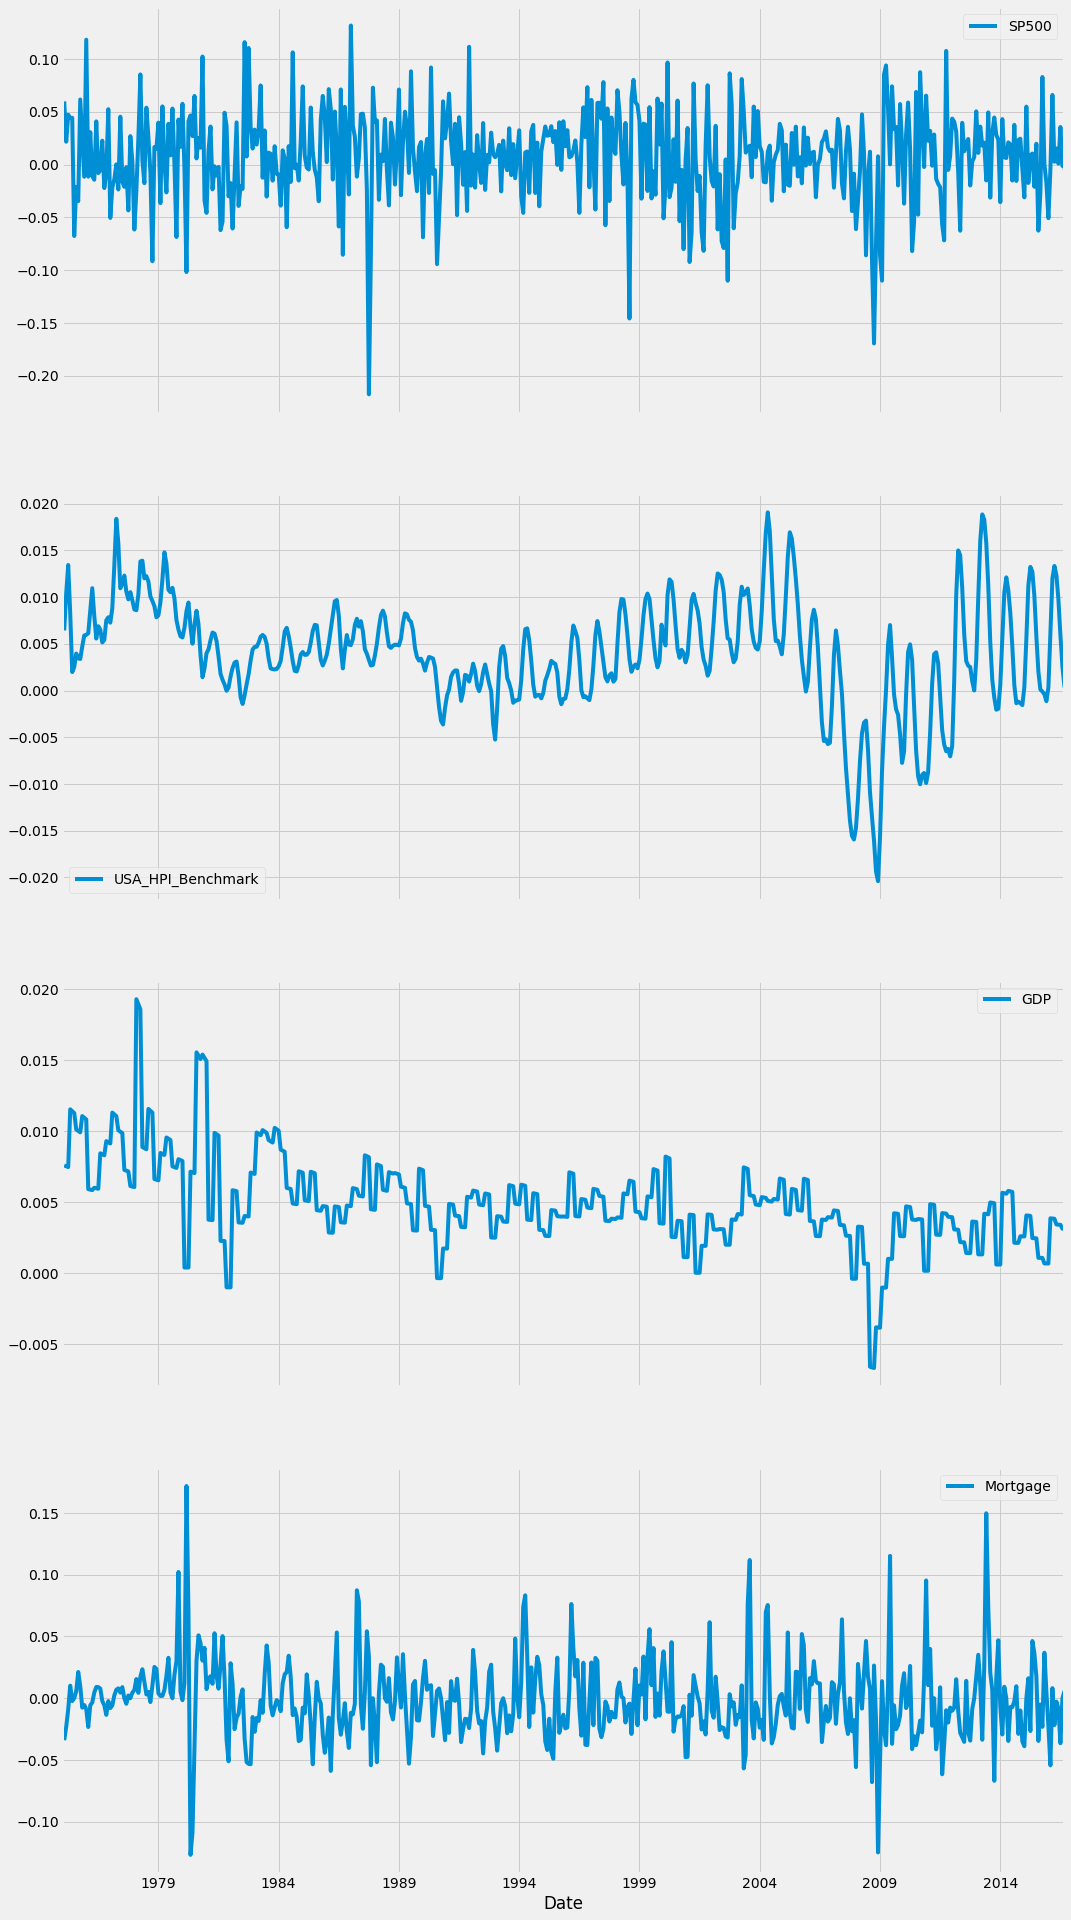

In [6]:
# Draw graphs of SP500 rates/USA HPI Benchmarks/GDP/Mortgage rates and checking Correlation
df_sp500 = get_sp500_rates()
df_benchmark = get_hpi_benchmark()
df_gdp = get_gdp_rates()
df_mortgage = get_mortgage_rates()

plt.clf()

fig = plt.figure(figsize=(16,32))
ax1 = plt.subplot2grid((4,1), (0,0))
ax2 = plt.subplot2grid((4,1), (1,0), sharex=ax1)
ax3 = plt.subplot2grid((4,1), (2,0), sharex=ax1)
ax4 = plt.subplot2grid((4,1), (3,0), sharex=ax1)

# Joining data to run the correlation
df_sp500.plot(ax=ax1)
df_benchmark.plot(ax=ax2)
df_gdp.plot(ax=ax3)
df_mortgage.plot(ax=ax4)

plt.show()

In [7]:
# Our supervised learning code should take as features:
#   - S&P500 price pct changes, 
#   - Mortgage pct change rates, 
#   - HPI pct change
#   - GDP pct change
# Now we just have to create a new column to indicate if with these features the HPI 
# will go up or down and use it to build our supervised learning model with Sklearn
df_all = df_sp500.join([df_benchmark, df_gdp, df_mortgage])
df_all.head()

,SP500,USA_HPI_Benchmark,GDP,Mortgage
Date,,,,
1975-01-31,NaN,NaN,NaN,NaN
1975-02-28,0.059886,0.006439,0.007594,-0.033934
1975-03-31,0.021694,0.010424,0.007536,-0.023052
1975-04-30,0.047265,0.013442,0.007480,-0.008989
1975-05-31,0.044101,0.008275,0.011544,0.010204


In [8]:
# Firstly, let's clear the data as we know there are some NaN and (+/-) infinite pct values
df_all.replace([np.inf, -np.inf], np.nan, inplace=True)
df_all.dropna(inplace=True)

# Now create the future column based on the HPI column values shifted
df_all['USA_HPI_Benchmark_Future'] = df_all['USA_HPI_Benchmark'].shift(-1)
df_all.head()

,SP500,USA_HPI_Benchmark,GDP,Mortgage,USA_HPI_Benchmark_Future
Date,,,,,
1975-02-28,0.059886,0.006439,0.007594,-0.033934,0.010424
1975-03-31,0.021694,0.010424,0.007536,-0.023052,0.013442
1975-04-30,0.047265,0.013442,0.007480,-0.008989,0.008275
1975-05-31,0.044101,0.008275,0.011544,0.010204,0.001974
1975-06-30,0.044323,0.001974,0.011412,-0.002245,0.002518


In [9]:
# Adjusting this column to have a binary value to teach our classifier 
# if the HPI is going up (1) or down (0)
def up_or_down(current, future):
    if future > current:
        return 1
    else:
        return 0
df_all['USA_HPI_Benchmark_Future'] = list(map(up_or_down, df_all['USA_HPI_Benchmark'], df_all['USA_HPI_Benchmark_Future']))
df_all.head()    

,SP500,USA_HPI_Benchmark,GDP,Mortgage,USA_HPI_Benchmark_Future
Date,,,,,
1975-02-28,0.059886,0.006439,0.007594,-0.033934,1
1975-03-31,0.021694,0.010424,0.007536,-0.023052,1
1975-04-30,0.047265,0.013442,0.007480,-0.008989,0
1975-05-31,0.044101,0.008275,0.011544,0.010204,0
1975-06-30,0.044323,0.001974,0.011412,-0.002245,1


In [10]:
# Using Support Vector Machine (SVM) to train our model
# Choosing the right estimator: http://scikit-learn.org/stable/tutorial/machine_learning_map/index.html
from sklearn import svm, preprocessing, model_selection

# Creating features and labels (preprocessing features to avoid scale problems)
# From features matrix we must remove the label - Sure, it has 100% correlation with the label, i.e. results :)
X = np.array(df_all.drop(['USA_HPI_Benchmark_Future'], 1)) 
X = preprocessing.scale(X)
y = np.array(df_all['USA_HPI_Benchmark_Future'])

# Defining the train and test sets using the sklearn API
X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, test_size=0.2)

# Creating the classifier
svm_classifier = svm.SVC(kernel='linear')
svm_classifier.fit(X_train, y_train)

# right = sum((svm_classifier.predict(X_test)==y_test))
# all = y_test.shape[0]
# acuracy = right/all
accuracy = svm_classifier.score(X_test, y_test)
print("Accuracy found: {0:4.2f}%". format(accuracy*100))

Accuracy found: 62.00%
